In [115]:
from dotenv import load_dotenv
load_dotenv()

True

In [116]:
MODEL_NAME = "gpt-4o-mini"

## Tools

### PDF Retriever and Retrieval Chain

In [117]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드합니다.
pdf_chain_obj = PDFRetrievalChain(["data/RAGwithLangChain.pdf"]).create_chain()

# retriever와 chain을 생성합니다.
pdf_retriever = pdf_chain_obj.retriever
pdf_chain = pdf_chain_obj.chain

CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


data/RAGwithLangChain.pdf


In [118]:
pdf_chain

{
  question: RunnableLambda(itemgetter('question')),
  context: RunnableLambda(itemgetter('context')),
  chat_history: RunnableLambda(itemgetter('chat_history'))
}
| PromptTemplate(input_variables=['chat_history', 'context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'teddynote', 'lc_hub_repo': 'rag-prompt-chat-history', 'lc_hub_commit_hash': '9ca39c3b3a117e4f8408d51bd71a87fc17fe6fd1d01986c449eecaebc02d549f'}, template="You are an AI assistant specializing in Question-Answering (QA) tasks within a Retrieval-Augmented Generation (RAG) system. \nYour primary mission is to answer questions based on provided context or chat history.\nEnsure your response is concise and directly addresses the question without any additional narration.\n\n###\n\nYou may consider the previous conversation history to answer the question.\n\n# Here's the previous conversation history:\n{chat_history}\n\n###\n\nYour final answer should be written concisely (but include importan

In [119]:
pdf_retriever

VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000001DB34B491D0>, search_kwargs={'k': 10})

### Query Router (Vector store or Web Search)

#### Route Prompt

In [120]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

system_message = """ You are an expert at routing user queries to either a vectorstore or a web search engine.
                     The vectorstore contains documents specifically about RAG and LangChain.
                     If the query is related to RAG or LangChain, use the vectorstore. For all other topics, use the web search engine. """

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_message),
        ("human", "{query}"),
    ]
)

#### Query Router

In [121]:
class RouteQuery(BaseModel):
    """ Route a user query to the most relevant datasource """

    datasource: Literal["vector_store", "web_search"] = Field(
        ..., # required
        description= "Route the user query to either the vectorstore or the web search engine based on its content."
    )

llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery) # Convert the result to RouteQuery type.

query_router = route_prompt | structured_llm_router

#### Test Query Router

In [122]:
print(
    query_router.invoke(
        {"query": "RAG의 정의는?"}
    )
)

datasource='vector_store'


In [123]:
print(
    query_router.invoke(
        {"query": "판교에서 가장 맛있는 딤섬집 찾아줘"}
    )
)

datasource='web_search'


### Retrieval Grader

#### System Prompt

In [124]:
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

system = """ You are a grader evaluating the relevance of a retrieved document to a user query.
            If the document contains keywords or semantic meanings related to the query, consider it relevant.
            This is not a strict test — the goal is to filter out irrelevant results clearly.
            Return a binary score: "yes" if the document is relevant, or "no" if it is not."""

retrieval_grader_prompt  = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {documents} \n\n User query: {query}"),
    ]
)

#### Retrieval Grader

In [125]:
class GradeDocuments(BaseModel):
    binary_score: str = Field(
        description="Are the documents relevant to the user query? Answer 'yes' or 'no'."
    )

llm = ChatOpenAI(model=MODEL_NAME, temperature = 0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

retrieval_grader = retrieval_grader_prompt | structured_llm_grader

#### Test Retrieval Grader

In [126]:
query = "RAG가 뭐야?"
retrieved_docs = pdf_retriever.invoke(query)
retrieved_doc = retrieved_docs[1].page_content
print(retrieval_grader.invoke({"query":query, "documents":retrieved_doc}))

binary_score='yes'


In [127]:
filtered_docs = []
for doc in retrieved_docs:
    result = retrieval_grader.invoke(
        {
            "query": query,
            "documents": doc.page_content,
        }
    )
    if result.binary_score == "yes":
        filtered_docs.append(doc)

In [128]:
print(filtered_docs)

[Document(id='e788086e-c64e-4c4c-be12-de6e31054c84', metadata={'source': 'data/RAGwithLangChain.pdf', 'file_path': 'data/RAGwithLangChain.pdf', 'page': 1, 'total_pages': 14, 'Title': 'Part3. RAG with LangChain', 'Producer': 'macOS Version 12.3 (Build 21E230) Quartz PDFContext', 'Creator': 'Keynote', 'CreationDate': "D:20240423050512Z00'00'", 'ModDate': "D:20240423050512Z00'00'"}, page_content='PART\nRAG with LangChain'), Document(id='3eb790b9-4431-47c3-b521-022ab8f2da34', metadata={'source': 'data/RAGwithLangChain.pdf', 'file_path': 'data/RAGwithLangChain.pdf', 'page': 7, 'total_pages': 14, 'Title': 'Part3. RAG with LangChain', 'Producer': 'macOS Version 12.3 (Build 21E230) Quartz PDFContext', 'Creator': 'Keynote', 'CreationDate': "D:20240423050512Z00'00'", 'ModDate': "D:20240423050512Z00'00'"}, page_content='CLIP\nComparative Analysis of RAG\nFrameworks'), Document(id='3b479cb1-6c92-42b1-af75-fb90a89bf6ff', metadata={'source': 'data/RAGwithLangChain.pdf', 'file_path': 'data/RAGwithLan

### RAG Chain for answer generation

In [129]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

prompt = hub.pull("qa-rag-prompt/general")

llm = ChatOpenAI(model_name=MODEL_NAME, temperature=0)

def format_docs(retrieved_docs):
    return "\n\n".join(
        [
            f"""<document>
                    <content>
                        {doc.page_content}
                    </content>
                    <source>
                        {doc.metadata["source"]}
                    </source>
                    <page>
                        {doc.metadata.get("page", 0) + 1 if "page" in doc.metadata else "unknown"}
                    </page>
                </docuemnt>""" for doc in retrieved_docs
        ]
    )
rag_chain = prompt | llm | StrOutputParser()

In [130]:
answer = rag_chain.invoke({"context": format_docs(retrieved_docs), "query": query})
print(answer)

I don't know.


In [131]:
prompt

ChatPromptTemplate(input_variables=['context', 'query'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'qa-rag-prompt', 'lc_hub_repo': 'general', 'lc_hub_commit_hash': 'ed61f794b1d06a1dbf28e4e20f4e7f59234aa58d65ddca2ddae4d73adb3e3dd9'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'query'], input_types={}, partial_variables={}, template='You are an AI assistant specializing in Question-Answering (QA) tasks within a Retrieval-Augmented Generation (RAG) system. \\n\\n\nYour primary mission is to answer queries based on the provided context or chat history. \\n\\n\nEnsure your response is concise and directly addresses the query without any additional narration. \\n\\n\n\nInstructions: \\n\\n \nCarefully read and understand the provided context. \\n\\n\n\nIdentify the key information relevant to the query. \\n\\n\n\nFormulate a concise answer based on the relevant information. \\n\\n\n\nEnsure your final answer directly addresse

### Hallucination Checker

#### Hallucination Check Prompt

In [132]:
system = """You are a grader assessing whether an LLM-generated answer is grounded in or supported by a set of provided facts.
            Provide a binary score: "yes" if the answer is grounded in the facts, or "no" if it is not."""

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {answer}")
    ]
)

#### Hallucination Checker

In [133]:
class CheckHallucinations(BaseModel):
    binary_score: Literal["yes", "no"] = Field(
        description = "Indicate whether the answer is grounded in the provided facts. Use 'yes' if it is, or 'no' if it is not."
    )

llm = ChatOpenAI(model=MODEL_NAME, temperature = 0)
structured_llm_checker = llm.with_structured_output(CheckHallucinations)

hallucination_checker = hallucination_prompt | structured_llm_checker

In [134]:
hallucination_checker.invoke({"documents": retrieved_docs, "answer": answer})

CheckHallucinations(binary_score='no')

### Answer Evaluator

#### Answer Evaluation Prompt

In [135]:
system = """ You are an evaluator assessing whether the answer sufficiently addresses or resolves the user query.
            Provide a binary score: "yes" if the answer resolves the query, or "no" if it does not. """
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User query: \n\n {query} \n\n LLM answer: {answer}"),
    ]
)

#### Answer Evaluator

In [136]:
class EvaluateAnswer(BaseModel):
    binary_score: str = Field(
        description="Respond with 'yes' or 'no' to indicate if the answer resolves the query."
    )

llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
structured_llm_grader = llm.with_structured_output(EvaluateAnswer)

answer_evaluator = answer_prompt | structured_llm_grader

In [137]:
answer_evaluator.invoke({"query": query, "answer": answer})

EvaluateAnswer(binary_score='no')

### Query Rewriter

In [138]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

system = """You are a query rewriter tasked with optimizing input queries for vectorstore retrieval. 
            Examine the query carefully and reason about its underlying semantic meaning."""

rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Here is the initial query: \n\n {query} \n Formulate an improved query.")
    ]
)

query_rewriter = rewrite_prompt | llm | StrOutputParser()

In [139]:
query_rewriter.invoke({"query", query})

"{'query': 'RAG의 정의와 의미는 무엇인가요?'}"

### Web Search tool

In [ ]:
from utils.websearch import TavilySearch

web_search_tool = TavilySearch(max_results = 2)

result = web_search_tool.search("랭그래프의 위키독스 URL을 알려주세요")
print(result)

## State Definition

In [106]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langgraph.graph import MessagesState
from typing import Any, Dict, List, Callable, Optional

class GraphState(MessagesState):
    query: Annotated[str, "User query"]
    answer: Annotated[str, "LLM generated answer"]
    documents: Annotated[List[str], "List of documents"]
    source: Annotated[str, "Data source"]

## Funcs for Conditional Edges

In [107]:
def route_query(state):
    print("=== [ROUTE QUERY] ===")

    query = state["query"]

    routing_result = query_router.invoke({"query":query})

    if routing_result.datasource == "web_search":
        print("--- [ROUTING QUERY TO WEB SEARCH] ---")
        return "web_search"
    elif routing_result.datasource == "vector_store":
        print("--- [ROUTING QUERY TO VECTOR STORE] ---")
        return "vector_store"
    else:
        print(f"예상치 못한 datasource: {routing_result.datasource}")
        return "vector_store"  # fallback

def check_hallucination(state):
    print(" === [CHECK HALLUCINATION] ===")
    source = state["source"]
    retrieved_documents = state["documents"]
    answer = state["answer"]

    result = hallucination_checker.invoke(
        {"documents": retrieved_documents, "answer": answer}
    )
    grade = result.binary_score

    if grade == "no":
        if source == "vector_store":
            return "vector store hallucination"
        elif source == "web_search":
            return "web search hallucination"
        else:
            print("The source is ambigous.", source)
            return "no hallucination"
    else:
        return "no hallucination"

def decide_to_generate(state):
    print("=== [DECISION TO GENERATE ANSWER] ===")
    filtered_documents = state["documents"]

    if not filtered_documents:
        print("--- [NO RELEVANT DOCUMENT FOUND] ---")
        return "give up"
    else:
        print("--- [RELEVANT DOCUMENTS FOUND] ---")
        return "generate_answer"

## Node Definition

In [108]:
from langchain_core.documents import Document

def retrieve(state):
    print("=== [RETRIEVE] ===")
    
    query = state["query"]

    retrieved_documents = pdf_retriever.invoke(query)
    return {"documents": retrieved_documents, "source": "vector_store"}

def generate_answer(state):
    print("=== [GENERATE ANSWER] ===")
    query = state["query"]
    retrieved_documents = state["documents"]

    answer = rag_chain.invoke({"context": format_docs(retrieved_documents), "query": query})
    return {"answer": answer} 

def filter_documents(state):
    print("=== [GRADE RETREIVED DOCUMENTS] ===")
    query = state["query"]
    retrieved_documents = state["documents"]

    filtered_docs = []
    for doc in retrieved_documents:
        result = retrieval_grader.invoke(
            {"query": query, "documents": doc.page_content}
        )
        grade = result.binary_score

        if grade == "yes":
            print("--GRADE: DOC IS RELEVANT---")
            filtered_docs.append(doc)
        else:
            print("--GRADE: DOC IS IRRELEVANT---")
            continue
    return {"documents": filtered_docs}

def rewrite_query(state):
    print("===[REWRITE QUERY]===")
    query = state["query"]

    better_query = query_rewriter.invoke({"query": query})
    return {"query": better_query}

def search_web(state):
    print("=== [WEB SEARCH]===")
    
    query = state["query"]
    
    web_results = web_search_tool.invoke({"query": query})
    print("CHECK: ", len(web_results))
    web_docs = [
        Document( 
            page_content = web_result["content"],
            metadata={"source": web_result["url"]}
            ) 
            for web_result in web_results
    ]

    print("ALGUD IN THE HOOD.")
    return {
                "documents": web_docs,
                "source": "web_search"
            }





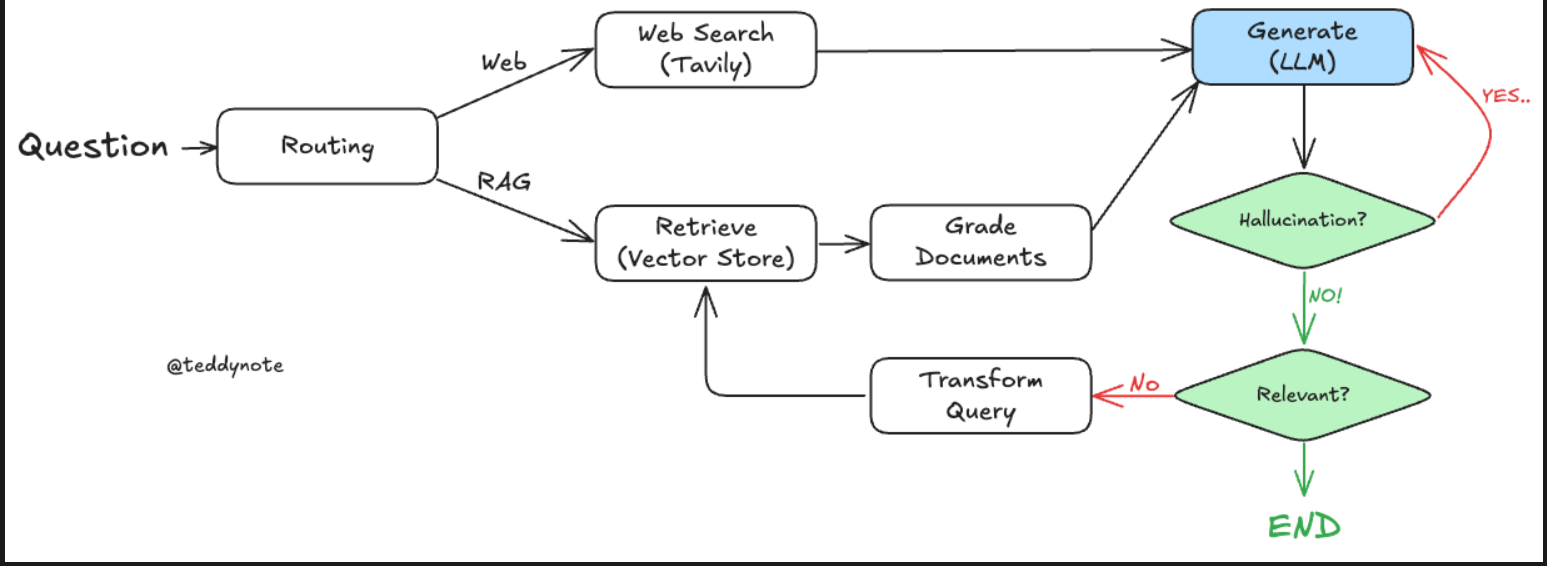

## Graph Definition

In [109]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableLambda

workflow = StateGraph(GraphState)

# Adding nodes
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("search_web", search_web)
workflow.add_node("retrieve", retrieve)
workflow.add_node("filter_documents", filter_documents)
workflow.add_node("generate_answer", generate_answer)

# Adding edges
workflow.add_edge(START, "rewrite_query")
workflow.add_conditional_edges(
    "rewrite_query",
    route_query,
    {
        "web_search": "search_web",
        "vector_store": "retrieve"
    },
)

workflow.add_edge("search_web", "generate_answer")
workflow.add_edge("retrieve", "filter_documents")

workflow.add_conditional_edges(
    "filter_documents",
    decide_to_generate,
    {
        "give up": END,
        "generate_answer": "generate_answer",
    }
)

workflow.add_conditional_edges(
    "generate_answer",
    check_hallucination,
    {
        "no hallucination": END,
        "vector store hallucination": "generate_answer", # Re-generate answer since there's hallucination
        "web search hallucination": "search_web", # Re-generate answer since there's hallucination
    }    
)

app = workflow.compile(checkpointer=MemorySaver())

In [110]:
# from utils.visualize import visualize_graph
# visualize_graph(app)

In [111]:
mermaid_code = app.get_graph().draw_mermaid()
print(mermaid_code)

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	rewrite_query(rewrite_query)
	search_web(search_web)
	retrieve(retrieve)
	filter_documents(filter_documents)
	generate_answer(generate_answer)
	__end__([<p>__end__</p>]):::last
	__start__ --> rewrite_query;
	filter_documents -. &nbsp;give up&nbsp; .-> __end__;
	filter_documents -.-> generate_answer;
	generate_answer -. &nbsp;no hallucination&nbsp; .-> __end__;
	generate_answer -. &nbsp;web search hallucination&nbsp; .-> search_web;
	retrieve --> filter_documents;
	rewrite_query -. &nbsp;vector_store&nbsp; .-> retrieve;
	rewrite_query -. &nbsp;web_search&nbsp; .-> search_web;
	search_web --> generate_answer;
	generate_answer -. &nbsp;vector store hallucination&nbsp; .-> generate_answer;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [112]:
from langchain_core.runnables import RunnableConfig
from langgraph.graph.state import CompiledStateGraph
def invoke_graph(
    graph: CompiledStateGraph,
    inputs: dict,
    config: RunnableConfig,
    node_names: List[str] = [],
    callback: Callable = None,
):
    """
    Prints the output of the app in a customized format. 

    Args:
        graph (CompiledStateGraph): 실행할 컴파일된 LangGraph 객체
        inputs (dict): 그래프에 전달할 입력값 딕셔너리
        config (RunnableConfig): 실행 설정
        node_names (List[str], optional): 출력할 노드 이름 목록. 기본값은 빈 리스트
        callback (Callable, optional): 각 청크 처리를 위한 콜백 함수. 기본값은 None
            콜백 함수는 {"node": str, "content": str} 형태의 딕셔너리를 인자로 받습니다.

    Returns:
        None: 함수는 스트리밍 결과를 출력만 하고 반환값은 없습니다.
    """

    def format_namespace(namespace):
        return namespace[-1].split(":")[0] if len(namespace) > 0 else "root graph"

    # subgraphs=True 를 통해 서브그래프의 출력도 포함
    for namespace, chunk in graph.stream(
        inputs, config, stream_mode="updates", subgraphs=True
    ):
        for node_name, node_chunk in chunk.items():
            # node_names가 비어있지 않은 경우에만 필터링
            if len(node_names) > 0 and node_name not in node_names:
                continue

            # 콜백 함수가 있는 경우 실행
            if callback is not None:
                callback({"node": node_name, "content": node_chunk})
            # 콜백이 없는 경우 기본 출력
            else:
                print("\n" + "=" * 50)
                formatted_namespace = format_namespace(namespace)
                if formatted_namespace == "root graph":
                    print(f"🔄 Node: \033[1;36m{node_name}\033[0m 🔄")
                else:
                    print(
                        f"🔄 Node: \033[1;36m{node_name}\033[0m in [\033[1;33m{formatted_namespace}\033[0m] 🔄"
                    )
                print("- " * 25)

                # 노드의 청크 데이터 출력
                if isinstance(node_chunk, dict):
                    for k, v in node_chunk.items():
                        if isinstance(v, BaseMessage):
                            v.pretty_print()
                        elif isinstance(v, list):
                            for list_item in v:
                                if isinstance(list_item, BaseMessage):
                                    list_item.pretty_print()
                                else:
                                    print(list_item)
                        elif isinstance(v, dict):
                            for node_chunk_key, node_chunk_value in node_chunk.items():
                                print(f"{node_chunk_key}:\n{node_chunk_value}")
                        else:
                            print(f"\033[1;32m{k}\033[0m:\n{v}")
                else:
                    if node_chunk is not None:
                        for item in node_chunk:
                            print(item)
                print("=" * 50)

In [113]:
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.errors import GraphRecursionError

config = RunnableConfig(recursion_limit=5, configurable={"thread_id": "1"})

user_input = GraphState(query="이영진이 누구지?")

try:
    invoke_graph(app, user_input, config, [])
except GraphRecursionError as recursion_error:
    print(f"GraphRecursionError: {recursion_error}")

===[REWRITE QUERY]===
=== [ROUTE QUERY] ===
--- [ROUTING QUERY TO WEB SEARCH] ---

🔄 Node: rewrite_query 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
query:
이영진에 대한 정보는 무엇인가요?
=== [WEB SEARCH]===
CHECK:  2
ALGUD IN THE HOOD.

🔄 Node: search_web 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
page_content='골 때리는 그녀들에 모델 겸 배우 이영진에 대한 관심이 높습니다. 이영진은 앞서 지난 2021년 12월 8일 골 때리는 그녀들에 fc액셔니스타의 새 멤버로 합류했지만 연습 경기에서 햄스트링 부상을 당해 경기에 출전하지 못해 아쉬움을 안긴 바 있습니다. 하지만 이후 지난해(2022) 2월 다시 복귀, 지금까지' metadata={'source': 'https://mway2.tistory.com/4083'}
page_content='이영진 프로필 나이 결혼 남편 배정훈 모델겸 배우 이영진의 최근 소식으로는 sbs 예능 프로그램 '골때리는 그녀들'에서 '액셔니 스타' 팀으로 맹활약 하고 있습니다. 오늘은 배우 이영진에 대해서 알아보는 시간을 가져보려고 하는데 이영진 프로필 정보와 나이 리즈 과거얼굴 고향 결혼 남편 남자' metadata={'source': 'https://dictionarypeople.tistory.com/1628'}
source:
web_search
=== [GENERATE ANSWER] ===
 === [CHECK HALLUCINATION] ===

🔄 Node: generate_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
answer:
I don't know.
=== [WEB SEARCH]===
CHECK:  2
ALG

In [114]:
print("D")

D
